# 🌍 Travel Guide Bot: Guibo

**Team** \
FullName (Kaggle Id)             - Gmail \
Rahul Payeli (rahulpayeli67)   - payelirahul0@gmail.com \
Prathamesh Naik (prathamnaik922) - prathameshnaik922@gmail.com \
Nicole Burns (nicolesamantha)   - nicole.samantha.5279@gmail.com \
Sayali Duragkar (sayali0828)  - duragkarsayali0897@gmail.com


**Use Case:**  
Travel planning today often means juggling half a dozen apps—switching from flight‐booking sites to hotel reviews, restaurant guides, attraction listings, and local event calendars—all while trying to keep dates, budgets, and preferences straight. It’s easy to miss a better deal or overlook the perfect hidden gem simply because you’ve grown weary of copying and pasting between tabs. What travelers really need is a single, conversational companion that feels like a savvy local guide—one that can instantly pull up real‑time flight options, recommend top‑rated hotels, suggest the best nearby restaurants and must‑see attractions, and even propose the next logical step in your itinerary—all within one seamless chat. Guibo is exactly that: your all‑in‑one travel assistant, sparing you the app‑hop and delivering personalized recommendations in natural conversation.

---

## What we are using to build our agent/travel bot?

- ### Grounding (Real‑time Web Search)  
  - Uses Vertex AI’s Gemini model configured with a `GoogleSearch` tool (via `GenerateContentConfig`) to fetch live, authoritative information for any query the user poses (e.g. ticket prices, local events, travel advisories).

- ### Function Calling 
  - Implements five LangChain‑style `@tool` functions:  
    1. `get_info(query: str) → str` for arbitrary destination queries  
    2. `find_hotels(location: str) → str` for top hotel options  
    3. `find_restaurants(location: str) → str` for dining recommendations  
    4. `find_flights(origin: str, destination: str, …) → str` for flight schedules & pricing  
  - Each tool handles input validation, error catching, and returns a structured Markdown/JSON snippet.

- ### Structured Output / JSON Mode 
  - Every tool returns data in a concise Markdown/JSON format—tables of hotel listings, bullet lists of restaurant options, flight details with times & links—making the notebook readable.

- ### Agent 
  - Built a **LangGraph** `StateGraph` with four nodes—**chatbot**, **tools**, **followup**, and **human**—to:  
    1. Decide when and which `@tool` to call  
    2. Execute the tool and render its output  
    3. Auto‑generate a context‑aware next question (e.g. after showing flight options: “Would you like me to check hotel availability?”)  
    4. Loop back for the user’s reply, creating a dynamic travel‑planning agent  

---

## Gen AI Capabilities Demonstrated

1. **Grounding** — Live web search via Gemini’s GoogleSearch tool  
2. **Function Calling** — `@tool` functions for each external query  
3. **Structured Output/JSON Mode** — Markdown & JSON‑formatted tool responses  
4. **Agents** — LangGraph implementation  

## 🛠️ Environment Setup

Before we begin, we need to ensure our notebook is using the correct versions of all dependencies and remove any conflicting packages left over in the Kaggle base image.

In [1]:
# Uninstall conflicting packages to avoid version clashes
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

# Reinstall the exact versions of our core GenAI libraries
!pip install -U 'langgraph==0.3.21' \
               'langchain-google-genai==2.1.2' \
               'langgraph-prebuilt==0.1.7' \
               --force-reinstall

# Install utility libraries for caching, retries, and data processing
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1

## 📦 Imports & Configuration

In this section, we load all of the libraries, clients, and types we’ll need.

In [2]:
import os
from kaggle_secrets import UserSecretsClient         # secure access to stored API keys
from google import genai                             # Vertex AI GenAI client
from google.genai import types                        # types for GenerateContentConfig, Tool, etc.

import requests_cache                                # caching HTTP responses
from retry_requests import retry                      # automatic retry on request failures

import pandas as pd                                   # data handling
import io, re                                         # I/O streams & regex utilities

from typing import Annotated, Literal
from typing_extensions import TypedDict               # for our TravelBotState TypedDict

# LangGraph core
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode               # helper to wrap @tool functions

# LangChain/GenAI LLM interface
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import Runnable
from langchain_core.tools import tool                  # decorator for our function‑calling tools

# LangChain message types for constructing prompts
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

# Notebook display helpers
from IPython.display import Image, Markdown, display

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


## 🔑 API & HTTP Client Setup

In this cell, we securely load our Google API key, initialize the Vertex AI client, and configure HTTP sessions with caching and retry logic.

In [3]:
# Load the Google API key from a secure store and set it in the environment
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# Instantiate the GenAI client for all future Gemini calls
client = genai.Client(api_key=GOOGLE_API_KEY)

# Configure a cached session to avoid redundant API hits (cache lives for 1 hour)
cache_session = requests_cache.CachedSession(
    '.cache', 
    expire_after=3600
)

# Wrap our cached session in a retry logic wrapper (up to 5 retries, exponential backoff)
retry_session = retry(
    cache_session,
    retries=5,
    backoff_factor=0.2
)

## 🤖 TravelBot Core: State, Tools & Agent Graph

### 1. Conversation State  
- Defines the `TravelBotState` TypedDict, which stores the full message history, the current destination, and a flag to signal when to end the chat.

### 2. System Prompt & Welcome  
- Sets `TRAVELBOT_SYSINT` to establish the bot’s persona, available tools, and response style.  
- Defines `WELCOME_MSG` as the initial greeting the bot sends when the conversation begins.

### 3. Google Search Configuration  
- Builds a `GenerateContentConfig` that connects Gemini’s `GoogleSearch` tool into our LLM for live, grounded web queries.

### 4. Helper Functions  
- Implements `google_search()` to invoke the Gemini search tool with a custom prompt.  
- Implements `get_links()` to extract and format source URLs from the search response.

### 5. Tool Definitions  
- Declares four `@tool` functions—`get_info`, `find_hotels`, `find_restaurants`, `find_flights`, each wraping a distinct data source with input validation and structured Markdown output.

### 6. LLM & Tool Binding  
- Instantiates a `ChatGoogleGenerativeAI` model (`gemini-2.0-flash`) and binds the above tools via `langchain.bind_tools`, enabling the LLM to call them as needed.

### 7. Routing Nodes  
- Defines `maybe_route_to_tools()` to detect when the LLM has issued a function call or should hand back to the user.  
- Defines `maybe_exit_human_node()` to terminate the session if the user types “q” or “goodbye.”

### 8. Follow‑Up Logic  
- Creates `followup_node()`, an LLM‑only step that reviews the last user question and tool output, then generates a context‑aware “next question” to advance the planning flow.

### 9. StateGraph Assembly  
- Uses `StateGraph` to wire together the four nodes (`chatbot`, `tools`, `followup`, `human`).
- Compiles this into `chat_with_human_graph`, our complete multi‑step travel planning agent.

In [4]:
# Conversation State Definition
class TravelBotState(TypedDict):
    messages: Annotated[list, add_messages] # full history of messages & tool calls
    destination: str # extracted city/attraction
    finished: bool # whether to end the conversation

# System & Welcome Messages
TRAVELBOT_SYSINT = (
    "system",
    "You are TravelBot, a helpful travel assistant designed to support users with destination-related questions and travel planning. "
    "You can provide information about traveling modes, popular attractions, ticket details, local events, hotel options, restaurants, and more. "
    "You must use available tools such as `find_hotels`, `find_restaurants`, `find_flights` and `get_info` when appropriate. "
    "Keep your responses concise, friendly, and clearly structured. Do not assist with any request that is unrelated to travel.\n\n"
    
    "If a user mentions a city, location, or tourist attraction, extract the destination and respond with relevant travel-related details. "
    "Use `get_info` to perform grounded web searches for up-to-date details about the destination, events, itineraries, ticket prices, or local recommendations. "
    "Only call `get_info` when the user query is related to travel and cannot be directly answered.\n\n"
    
    "Use `find_hotels` to provide hotel booking information, including hotel names, star ratings, price range, and booking links. "
    "Use `find_restaurants` to suggest top-rated restaurants in a location, including cuisine type, ratings, and links. "
    "Use `find_flights` to suggest flights booking links from origin to destination with flight ticket fare, ratings and other necesarry information related to flight \n\n"
    
    "If a required tool is not yet implemented, politely inform the user that the feature will be available soon.\n\n"
    
    "Always keep the conversation engaging. Based on the user's question, proactively follow up with relevant and helpful travel-related suggestions."

    "End the conversation when the user types 'q' or says goodbye.'\n\n"
)

WELCOME_MSG = "Hi there! I'm TravelBot, your personal travel guide. Ask me about any destination and I'll help you plan your visit! Type `q` to quit."

# Grounding Configuration for Gemini‑Powered Search
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def google_search(prompt: str) -> str:
    """
    Invoke Gemini’s GoogleSearch tool with a customized prompt.

    Args:
        prompt (str): The query or instruction for the web search.

    Returns:
        GenerateContentResponse: Contains the generated text and grounding links.
    """
    prompt = (
        f"{prompt}\n"
        f"Please do not include footnote numbers or citation markers like [1], [2], etc., in your response."
    )
    # Run the grounded Gemini search
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
        config=config_with_search
    )

    return response


def get_links(response: str, markdown_lines: list) -> str:
    """
    Append grounding metadata links to a list of Markdown lines.

    Args:
      response: The Gemini search response, which may include grounding_chunks.
      markdown_lines: The list of already‑assembled Markdown strings (headings, body text).

    Returns:
      A single Markdown string combining the original lines plus a “Sources” section
      with clickable links for each grounding chunk.
    """
    try:
        chunks = response.grounding_metadata.grounding_chunks
        if chunks:
            markdown_lines.append("\n**🔗 Sources:**")
            for chunk in chunks:
                title = chunk.web.title
                url = chunk.web.uri
                markdown_lines.append(f"- [{title}]({url})")
    except Exception:
        pass  

    markdown_output = "\n".join(markdown_lines)

    return markdown_output

@tool
def get_info(query: str) -> str:
    """
        Perform a grounded web search for `query` using Gemini’s GoogleSearch tool,
        format the results into a Markdown report (including source links), 
        and return the resulting Markdown string.
    """  
    prompt = (
        f"{query}\n"
        f"Please include links to websites or sources used in your answer wherever possible."
    )

    response = google_search(prompt)

    content_text = response.candidates[0].content.parts[0].text

    markdown_lines = [f"### 🔎 Search Results for: `{query}`", "", content_text]
    
    markdown_output = get_links(response, markdown_lines)
    display(Markdown(markdown_output))
    return markdown_output

@tool
def find_hotels(location: str) -> str:
    """
        Searches for top hotel booking options in the given location using a grounded web search,
        then returns a Markdown-formatted summary listing each hotel’s name, star rating,
        and booking URL, along with source citations.
    """
    prompt = (
        f"Find top hotel booking options in {location}. Please include links to websites or sources used in your answer wherever possible."
        f"List hotel names, star ratings, and include a booking URL for each hotel if available. "
        f"Only include hotels that can be booked online. Be concise."
    )

    
    response = google_search(prompt)
    text_response = response.candidates[0].content.parts[0].text
    markdown_lines = [f"### 🏨 Hotel Booking Options for {location}\n\n{text_response}"]
    
    markdown_output = get_links(response, markdown_lines)
    display(Markdown(markdown_output))
    return markdown_output

@tool
def find_restaurants(location: str) -> str:
    """
        Fetch and format a list of top-rated restaurants in the given location,
        including each restaurant’s name, cuisine type, star rating, and a booking
        or review link, returned as a markdown-formatted string.
    """
    prompt = (
        f"List top-rated restaurants in {location}. "
        f"Include name, cuisine type, star rating, and a booking or review link if available."
    )

    
    response = google_search(prompt)
    result = response.candidates[0].content.parts[0].text
    markdown_lines = [f"### 🍴 Restaurants in {location}\n\n{result}"]
    markdown_output = get_links(response, markdown_lines)
    display(Markdown(markdown_output))
    return markdown_output

@tool
def find_flights(origin: str, destination: str, departure_date: str, return_date: str) -> str:
    """
    Search for and return formatted flight options between two cities.

    This tool uses a grounded web search to retrieve available flights from
    `origin` to `destination` on the specified `departure_date`.

    Args:
        origin (str): Departure location.
        destination (str): Arrival location.
        departure_date (str): Departure date in YYYY-MM-DD format.
        return_date (str): (Optional) Return date in YYYY-MM-DD format.

    Returns:
        str: A Markdown-formatted string listing top flight options with links.
    """
    prompt = (
            f"Include specific airline names , {departure_date}/{return_date} timing, total flight durations (including layovers), "
            f"estimated prices, number of stops, and direct booking links or links to Google Flights/Skyscanner/Kayak if available. "
    )
    
    response = google_search(prompt)
    result = response.candidates[0].content.parts[0].text
    markdown_lines = [f"### Fligths from {origin} to {destination}\n\n{result}"]
    markdown_output = get_links(response, markdown_lines)
    display(Markdown(markdown_output))
    return markdown_output



# Bind tools to the LLM and wrap them in a ToolNode
tools = [find_hotels, get_info, find_restaurants, find_flights]
tool_node = ToolNode(tools)

# Initialize the Gemini-based chat model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                            temperature=0.3,
                            max_output_tokens=1000)

# Bind the tool functions so the LLM can call them automatically
tool_llm: Runnable = llm.bind_tools(tools)

def human_node(state: TravelBotState) -> TravelBotState:
    """
    This node handles all direct user interactions in the console:  
         - Displays the TravelBot’s most recent message.  
         - Prompts the user for their next input.  
         - Detects exit commands (`q`, `quit`, `exit`, `goodbye`) and flags the conversation to end.  
         - Appends the user’s reply into the shared `state["messages"]` so the agent can process it next.
    """
    last_msg = state["messages"][-1]
    print("\nTravelBot:", last_msg.content)
    user_input = input("You: ")
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True
    return state | {"messages": [("user", user_input)]}

def maybe_route_to_tools(state: TravelBotState) -> Literal["tools", "human"]:
    """
    Routing Node: This function decides whether the conversation should call an external tool or return to the user for more input. 
    It inspects the most recent message in the `state["messages"]` list:
        - If that message includes a `tool_calls` attribute , it returns `tools`, causing the graph to transition into your tool‑execution node.
        - Otherwise, it returns `human`, routing back to the node that waits for the next user message.
    """
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")
        
    msg = msgs[-1]

    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

def chatbot_with_tools(state: TravelBotState) -> TravelBotState:
    """
    Main chat handler that drives the LLM.
        - If prior messages exist, invokes the LLM using the system prompt plus history.  
        - If no messages exist, returns a welcome message. 
    """
    defaults = {"location": [], "finished": False}

    if state["messages"]:
        new_output = tool_llm.invoke([TRAVELBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    return defaults | state | {"messages": [new_output]}


def maybe_exit_human_node(state: TravelBotState) -> Literal["chatbot", "__end__"]:
    """
    Route to the end of the conversation if the user signaled exit, otherwise continue back to the chatbot node.
    """
    return END if state.get("finished", False) else "chatbot"


def followup_node(state: TravelBotState) -> TravelBotState:
    """
    This function is used to generate and append a context‑aware follow‑up question.

    Examines the user's last query and the tool’s most recent output,
    prompts the LLM to suggest the next helpful question (e.g., about hotels,
    restaurants, transportation, local events, etc.), and adds that question
    back into the conversation state.
    """
    
    last_tool_output = state["messages"][-1].content
    prev_user = state["messages"][-2].content
    prompt_messages = [
        SystemMessage(content=(
            "You are TravelBot, a helpful travel assistant. "
            "You’ve just answered the user’s question about:\n\n"
            f"   “{prev_user}”\n\n"
            f"with:\n\n{last_tool_output}\n\n"
            "Now think: what would be *the most helpful next question* "
            "to ask this traveler to move their planning forward? "
            "It should be relevant but can introduce a *new* facet—"
            "for example hotels, restaurants, transportation options, local events, "
            "packing tips, or seasonal recommendations—whichever fits best."
        )),
        HumanMessage(content="Please propose that next question.")
    ]

    followup_ai_msg: AIMessage = llm.invoke(prompt_messages)

    return state | {"messages": state["messages"] + [followup_ai_msg]}

# Initialize a new state machine for TravelBot
graph_builder = StateGraph(TravelBotState)

# Add the core nodes: chatbot_with_tools , human_node, tool_node, followup_node
graph_builder.add_node("chatbot", chatbot_with_tools) # decides when to call tools or reply
graph_builder.add_node("human", human_node)           # captures the user’s reply
graph_builder.add_node("tools", tool_node)            # runs any @tool calls from the LLM
graph_builder.add_node("followup", followup_node)     # creates context‑aware next questions

# Define routing rules:
# From chatbot: if a function_call was issued, go to tools; otherwise wait for user
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# From human: if user typed “q” or similar, end; otherwise go back to chatbot
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Link the tool → followup → human
graph_builder.add_edge("tools", "followup") # after running a tool, generate follow‑up question
graph_builder.add_edge("followup", "human") # then wait for the user’s next input

# Start the conversation at the chatbot node
graph_builder.add_edge(START, "chatbot")

# Compile the graph into a runnable object
chat_with_human_graph = graph_builder.compile()

## How the TravelBot Agent Behaves

1. **Start at `chatbot`**  
   - The LLM reviews the user’s latest message and, if it needs external data, emits a function call.

2. **Go to `tools`** (when a function call is present)  
   - The requested `@tool` (e.g. `get_info`, `find_hotels`) runs, fetches live data, and returns a structured Markdown/JSON snippet.

3. **Enter `followup`**  
   - Without human intervention, the LLM examines the tool’s output and the original user query, then crafts a context‑aware next question (e.g. “Would you like me to check hotel availability now?”).

4. **Switch to `human`**  
   - The bot presents that follow‑up and waits for your reply.  
   - If you respond normally, the cycle goes back to `chatbot`; if you type “q” or “goodbye,” it ends at `__end__`.

This loop—LLM decision, tool execution, dynamic follow‑up, and user input—creates a seamless, multi‑step travel‑planning conversation.```

## 📈 Visualizing the Agent Workflow

Use this chart to verify that nodes and edges match the intended conversation loop.

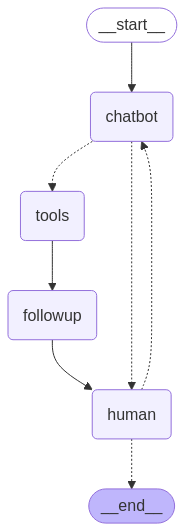

In [5]:
from IPython.display import Image
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

## 🚀 Let's play

You can now launch the agent:

- **`recursion_limit`** ensures the graph can recurse through its nodes without hitting Python’s default recursion depth.  
- **`invoke({"messages": []}, config)`** boots the agent with an empty history, causing it to emit the `WELCOME_MSG` as its first turn.  


In [6]:
'''
Please uncomment the lines to run the agent
'''
# config = {"recursion_limit": 100}
# state = chat_with_human_graph.invoke({"messages": []}, config)

'\nPlease uncomment the lines to run the agent\n'